# Structure generation and NEP training

This tutorial demonstrates a simple approach for generating an initial set of training structures for the construction of a NEP for bulk aluminium.

## Structure generation
First, we identify all the relevant prototype structures (FCC, BCC, HCP, diamond) that we want to include in the training set.

Next, we generate strained and deformed versions of the prototype structures.
Additionally, we include rattled supercells (of various sizes) with random atomic displacements.

Lastly, we note that if one wants to consider mixed alloy systems, defects, surfaces etc, one needs to be more careful during structure generation to include training structures such that one spans that part of the configurational space.

## Training
We use the function `setup_training` in calorine in order to set up and prepare all relevant files for the training.
Here, we use the [ASE EMT calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/emt.html) (instead of density functional theory) to compute energies, forces and stresses for the training structures to make the tutorial more lightweight.
After the NEP is trained we carry out some simple analysis of the model, specifically by constructing parity plots.

Note that the approach in this tutorial can be used to construct an initial NEP for the given system.
However, after training this initial model it is recommened to carry out a few iterations of active learning based on, e.g., molecular dynamics simulations to enhance the training set.

In [1]:
import numpy as np
from ase.build import bulk, make_supercell, surface
from ase.calculators.emt import EMT
from ase.io import write
from calorine.tools import relax_structure
from hiphive.structure_generation import generate_mc_rattled_structures

## Prototype structures
First, we collect all prototype structures of interest.

In [2]:
prototype_structures = {}
prototype_structures['fcc'] = bulk('Al', crystalstructure='fcc', a=4.05, cubic=True)
prototype_structures['bcc'] = bulk('Al', crystalstructure='bcc', a=3.12, cubic=True)
prototype_structures['hcp'] = bulk('Al', crystalstructure='hcp', a=2.82, c=4.47)
prototype_structures['diamond'] = bulk('Al', crystalstructure='diamond', a=6.1, cubic=True)

## Generation of strained and deformed prototype structures
Next, we generate strained and deformed versions of prototype structures.
`strain_lim` sets the range on how much we can strain or deform the cell of prototype structures.

In [3]:
def generate_strained_structure(prim, strain_lim):
    strains = np.random.uniform(*strain_lim, (3, ))
    atoms = prim.copy()
    cell_new = prim.cell[:] * (1 + strains)
    atoms.set_cell(cell_new, scale_atoms=True)
    return atoms


def generate_deformed_structure(prim, strain_lim):
    R = np.random.uniform(*strain_lim, (3, 3))
    M = np.eye(3) + R
    atoms = prim.copy()
    cell_new = M @ atoms.cell[:]
    atoms.set_cell(cell_new, scale_atoms=True)
    return atoms


# parameters
strain_lim = [-0.05, 0.05]
n_structures = 15

training_structures = []
for name, prim in prototype_structures.items():
    for it in range(n_structures):
        prim_strained = generate_strained_structure(prim, strain_lim)
        prim_deformed = generate_deformed_structure(prim, strain_lim)
        
        training_structures.append(prim_strained)
        training_structures.append(prim_deformed)

print('Number of training structures:', len(training_structures))

Number of training structures: 120


## Generation of rattled structures
We also include some rattled structures in the training set. One can use the functions `generate_rattled_structures` (for small displacements) and `generate_mc_rattled_structures` for larger displacements from `hiphive`, see the [hiphive documentation](https://hiphive.materialsmodeling.org/tutorial/prepare_reference_data.html#structure-generation) for more details.

The `d_min` parameter approximatley corresponds to the smallest interatomic distance we would like to see in the MC-rattled structures, here set to about 90% of the nearest neighbor distance.

The `rattle_std` and `n_iter` determines how large the displacements will, the displacements generated will roughly be `n_iter**0.5 * rattle_std`.

Note that it can be useful to include supercells of various system sizes as done below.

In [4]:
n_structures = 5
rattle_std = 0.04
d_min = 2.3
n_iter = 20

size_vals = {}
size_vals['fcc'] = [(2, 2, 2), (3, 3, 3), (4, 4, 4)]
size_vals['bcc'] = [(2, 2, 2), (3, 3, 3), (4, 4, 4)]
size_vals['hcp'] = [(2, 2, 2), (3, 3, 3), (4, 4, 4)]
size_vals['diamond'] = [(2, 2, 2), (3, 3, 3)]

In [5]:
for name, prim in prototype_structures.items():
    for size in size_vals[name]:
        for it in range(n_structures):
            supercell = generate_strained_structure(prim.repeat(size), strain_lim)
            rattled_supercells = generate_mc_rattled_structures(supercell, n_structures=1, rattle_std=rattle_std, d_min=d_min, n_iter=n_iter)
            print(f'{name}, size {size}, natoms {len(supercell)},  volume {supercell.get_volume() / len(supercell):.3f}')
            training_structures.extend(rattled_supercells)

fcc, size (2, 2, 2), natoms 32,  volume 15.172
fcc, size (2, 2, 2), natoms 32,  volume 15.632
fcc, size (2, 2, 2), natoms 32,  volume 16.313
fcc, size (2, 2, 2), natoms 32,  volume 15.371
fcc, size (2, 2, 2), natoms 32,  volume 16.363
fcc, size (3, 3, 3), natoms 108,  volume 17.138
fcc, size (3, 3, 3), natoms 108,  volume 16.230
fcc, size (3, 3, 3), natoms 108,  volume 16.765
fcc, size (3, 3, 3), natoms 108,  volume 16.382
fcc, size (3, 3, 3), natoms 108,  volume 16.574
fcc, size (4, 4, 4), natoms 256,  volume 16.577
fcc, size (4, 4, 4), natoms 256,  volume 16.360
fcc, size (4, 4, 4), natoms 256,  volume 15.217
fcc, size (4, 4, 4), natoms 256,  volume 16.771
fcc, size (4, 4, 4), natoms 256,  volume 16.530
bcc, size (2, 2, 2), natoms 16,  volume 15.222
bcc, size (2, 2, 2), natoms 16,  volume 15.300
bcc, size (2, 2, 2), natoms 16,  volume 15.490
bcc, size (2, 2, 2), natoms 16,  volume 14.301
bcc, size (2, 2, 2), natoms 16,  volume 15.108
bcc, size (3, 3, 3), natoms 54,  volume 15.863
bcc

We can visualize and inspect the training structures using the `view` function in ASE.

In [6]:
from ase.visualize import view

print('Number of training structures:', len(training_structures))

view(training_structures)

Number of training structures: 175


<Popen: returncode: None args: ['/home/elindgren/venvs/calorine/bin/python3'...>

## Training
We use the EMT calculator to compute the reference energies, forces and stresses.
We change some of the default NEP hyper-parameters, such as the number of neurons to 30.

Note that we only train for 100,000 generations.
In practice one should train until the model has converged, which typically requires many more generations.

In [7]:
# do reference calculations
for atoms in training_structures:
    atoms.calc = EMT()
    atoms.get_potential_energy()

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


In [8]:
from calorine.nep import setup_training

# prepare input for NEP construction
parameters = dict(version=4,
                  type=[1, 'Al'],
                  cutoff=[8, 4],
                  neuron=30,
                  generation=100000,
                  batch=1000000)

setup_training(parameters, training_structures, rootdir='training-tutorial', overwrite=True, n_splits=10)

The cell above sets up all required files for training in the `training-tutorial/` directory. In `training-tutorial/nepmodel_full` all structures are used for training, and in the `training-tutorial/nepmodel_split` directories 90% of the structures are used for training and 10% for testing, which is known as [K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) with `K=10`.

Next, one needs to go into each model directory (`training-tutorial/nepmodel_full` and `training-tutorial/nepmodel_split*`) and run `nep` in order to start the training. The training is computationally expensive and here with about 200 training structures takes about 2 hours on a A100 GPU.

## Analysis of the model
First we plot the total loss function, the L1 and L2 regularization part of the loss function and the corresponding RMSE (root mean squared error) for the full training set of the  `nepmodel_full` model.

We can see that the training has more or less converged with 100,000 generations.

In [9]:
import pandas as pd
from ase.units import GPa
from calorine.nep import get_parity_data, read_loss, read_structures
from matplotlib import pyplot as plt
from pandas import DataFrame, concat as pd_concat
from sklearn.metrics import r2_score, mean_squared_error

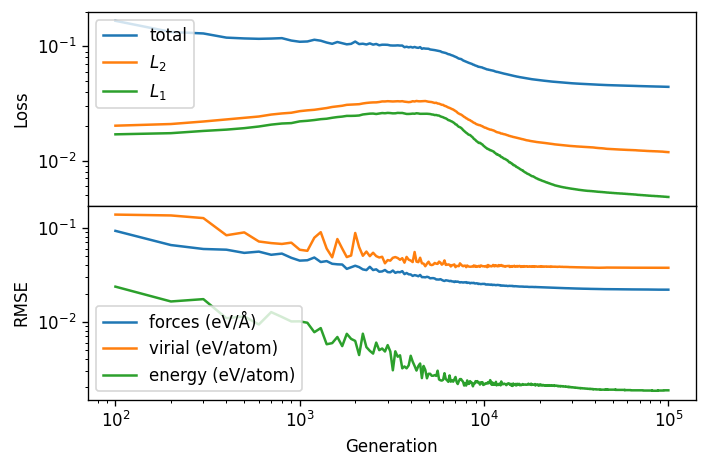

In [12]:
loss = read_loss('training-tutorial/nepmodel_full/loss.out')

fig, axes = plt.subplots(figsize=(6.0, 4.0), nrows=2,sharex=True, dpi=120)

ax = axes[0]
ax.set_ylabel('Loss')
ax.plot(loss.total_loss, label='total')
ax.plot(loss.L2, label='$L_2$')
ax.plot(loss.L1, label='$L_1$')
ax.set_yscale('log')
ax.legend()

ax = axes[1]
ax.plot(loss.RMSE_F_train, label='forces (eV/Å)')
ax.plot(loss.RMSE_V_train, label='virial (eV/atom)')
ax.plot(loss.RMSE_E_train, label='energy (eV/atom)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Generation')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
fig.align_ylabels(axes)

Finally, we plot the parity plots using the `read_structures` and `get_parity_data` functions.
We can see that the model does a good job of reproducing the reference data.

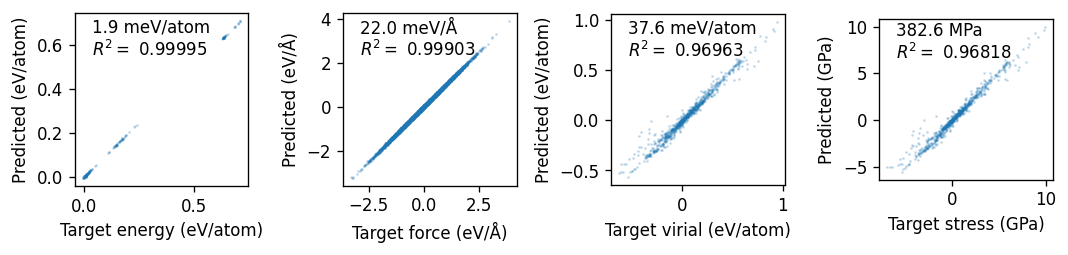

In [15]:
training_structures, _ = read_structures('training-tutorial/nepmodel_full')

units = dict(
    energy='eV/atom',
    force='eV/Å',
    virial='eV/atom',
    stress='GPa',
)

fig, axes = plt.subplots(figsize=(9.0, 2.6), ncols=4, dpi=120)
kwargs = dict(alpha=0.2, s=0.5)

for icol, (prop, unit) in enumerate(units.items()):
    df = get_parity_data(training_structures, prop, flatten=True)
    R2 = r2_score(df.target, df.predicted)
    rmse = np.sqrt(mean_squared_error(df.target, df.predicted))

    ax = axes[icol]
    ax.set_xlabel(f'Target {prop} ({unit})')
    ax.set_ylabel(f'Predicted ({unit})')
    ax.scatter(df.target, df.predicted, **kwargs)
    ax.set_aspect('equal')
    mod_unit = unit.replace('eV', 'meV').replace('GPa', 'MPa')
    ax.text(0.1, 0.75, f'{1e3*rmse:.1f} {mod_unit}\n' + '$R^2= $' + f' {R2:.5f}', transform=ax.transAxes)

fig.tight_layout()